In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from baryrat import aaa, brasil

%matplotlib inline

from src.helpers import calculate_relgap, plot_eigenvalues, get_FD_matrix
from src.experiments import approximation_convergence, get_bound_chebyshev, get_test_matrices
from src.phi import Phi

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Reading the test matrices

In [3]:
# orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
# bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
# gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
# helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

# Properties of the test matrices

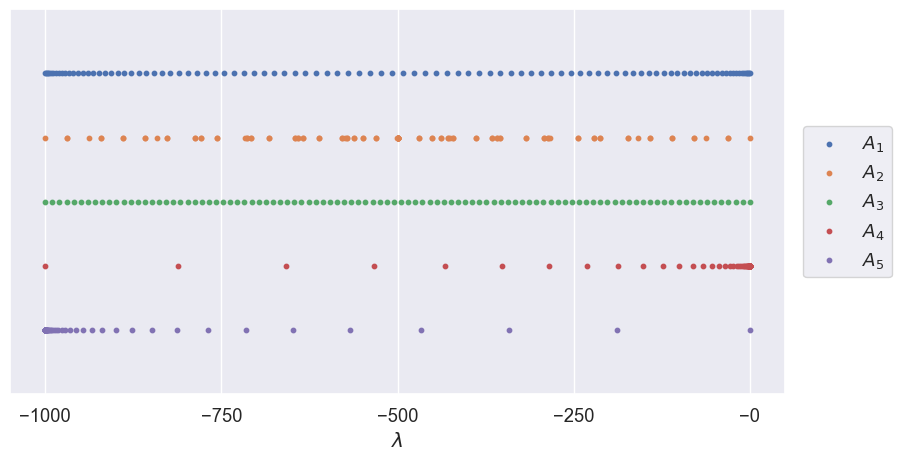

In [26]:
# Eigenvalue distribution

plot_eigenvalues(
    As=[*get_test_matrices(n=100, a=-1000, b=-1e-06)],
    legends=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$'],\
    xticks=[-1000, -750, -500, -250, -1e-06]
    # range_=(-1000, 0),
)

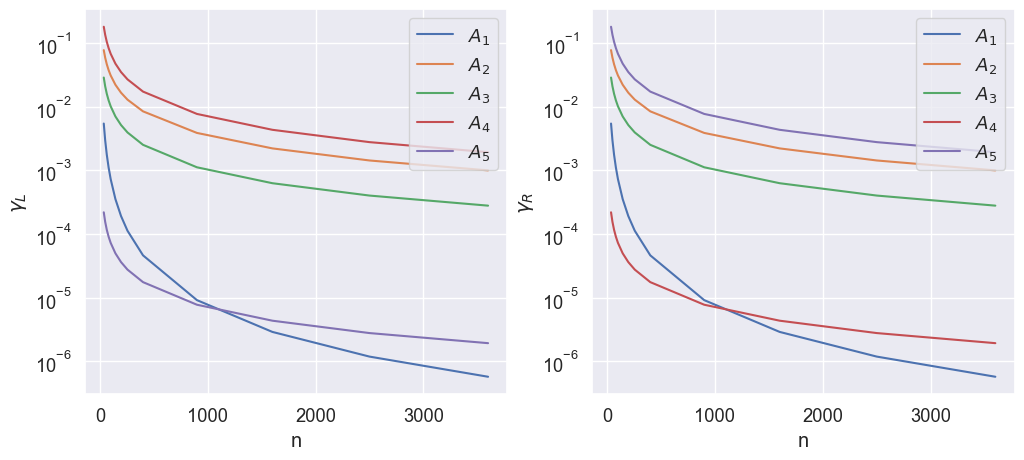

In [56]:
# Relative gap

names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
data = {'n': [], 'Matrix': [], 'g_l': [], 'g_r': []}
a, b = -1000, -1e-06
for n in [n ** 2 for n in [6, 7, 8, 9, 10, 12, 14, 16, 20, 30, 40, 50, 60]]:
    I = sps.identity(n=n)
    for idx, A in enumerate(get_test_matrices(n=n, a=a, b=b)):
        data['n'].append(n)
        data['Matrix'].append(names[idx])
        g_l, g_r = calculate_relgap(A, lam_min1=a, lam_max1=b)
        data['g_l'].append(g_l)
        data['g_r'].append(g_r)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_l', hue='Matrix', ax=axs[0])
axs[0].set(yscale='log', ylabel='$\gamma_L$', xlabel='n')
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_r', hue='Matrix', ax=axs[1])
axs[1].set(yscale='log', ylabel='$\gamma_R$', xlabel='n')
for ax in axs:
    ax.legend()

# Scalar $\varphi$-functions

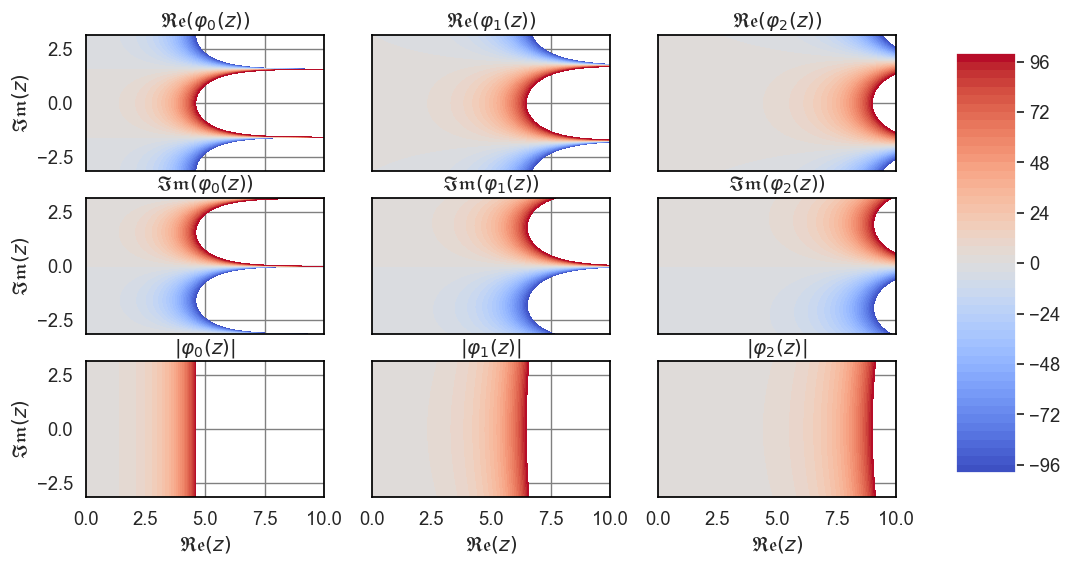

In [25]:
a = np.linspace(0, 10, 101)
b = np.linspace(-np.pi, np.pi, 101)
a, b = np.meshgrid(a, b)
z = a + 1j * b

ps = [0, 1, 2]
levels = np.linspace(-100, +100, 51)

fig, axs = plt.subplots(nrows=3, ncols=len(ps), figsize=(12, 6), sharey=True, sharex=True)
for idx, p in enumerate(ps):
    phi = Phi(p=p)
    r = phi.scalar(z)

    h0 = axs[0, idx].contourf(z.real, z.imag, r.real, levels=levels, cmap='coolwarm')
    h1 = axs[1, idx].contourf(z.real, z.imag, r.imag, levels=levels, cmap='coolwarm')
    h1 = axs[2, idx].contourf(z.real, z.imag, np.abs(r), levels=levels, cmap='coolwarm')
    axs[0, idx].set(title=f'$\\mathfrak{{Re}}(\\varphi_{phi.p}(z))$')
    axs[1, idx].set(title=f'$\\mathfrak{{Im}}(\\varphi_{phi.p}(z))$')
    axs[2, idx].set(title=f'$|\\varphi_{phi.p}(z)|$')

for ax in axs[-1, :]:
    ax.set(xlabel='$\\mathfrak{Re}(z)$')
for ax in axs[:, 0]:
    ax.set(ylabel='$\\mathfrak{Im}(z)$')
for ax in axs.flat:
    ax.grid(color='gray')
    ax.set(facecolor='white')
    for spine in ax.spines.values():
        spine.set_color('black')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(h0, cax=cbar_ax)

# The AAA and BRASIL algorithms

## What happens to `m` poles when $a \to -\infty$?

In [21]:
b = -1e-06
m = 5

nodes = []
poles_real = []
poles_imag = []
ps = []
as_ = []
for a in tqdm(-np.geomspace(1e02, 3e04, 10)):
    for p in [0, 1, 3, 5]:
        phi = Phi(p=p)

        nz = int(np.abs(a) / 2)
        Z = np.linspace(a, b, nz)
        r = aaa(Z=Z, F=phi.scalar, mmax=(m+1), tol=-1)
        # r = brasil(f=phi.scalar, interval=(a, -1), deg=m)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        ps.append(p)
        as_.append(a)

100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


[Text(45.36393554687501, 0.5, '$z_j \\in \\mathbb{R}$')]

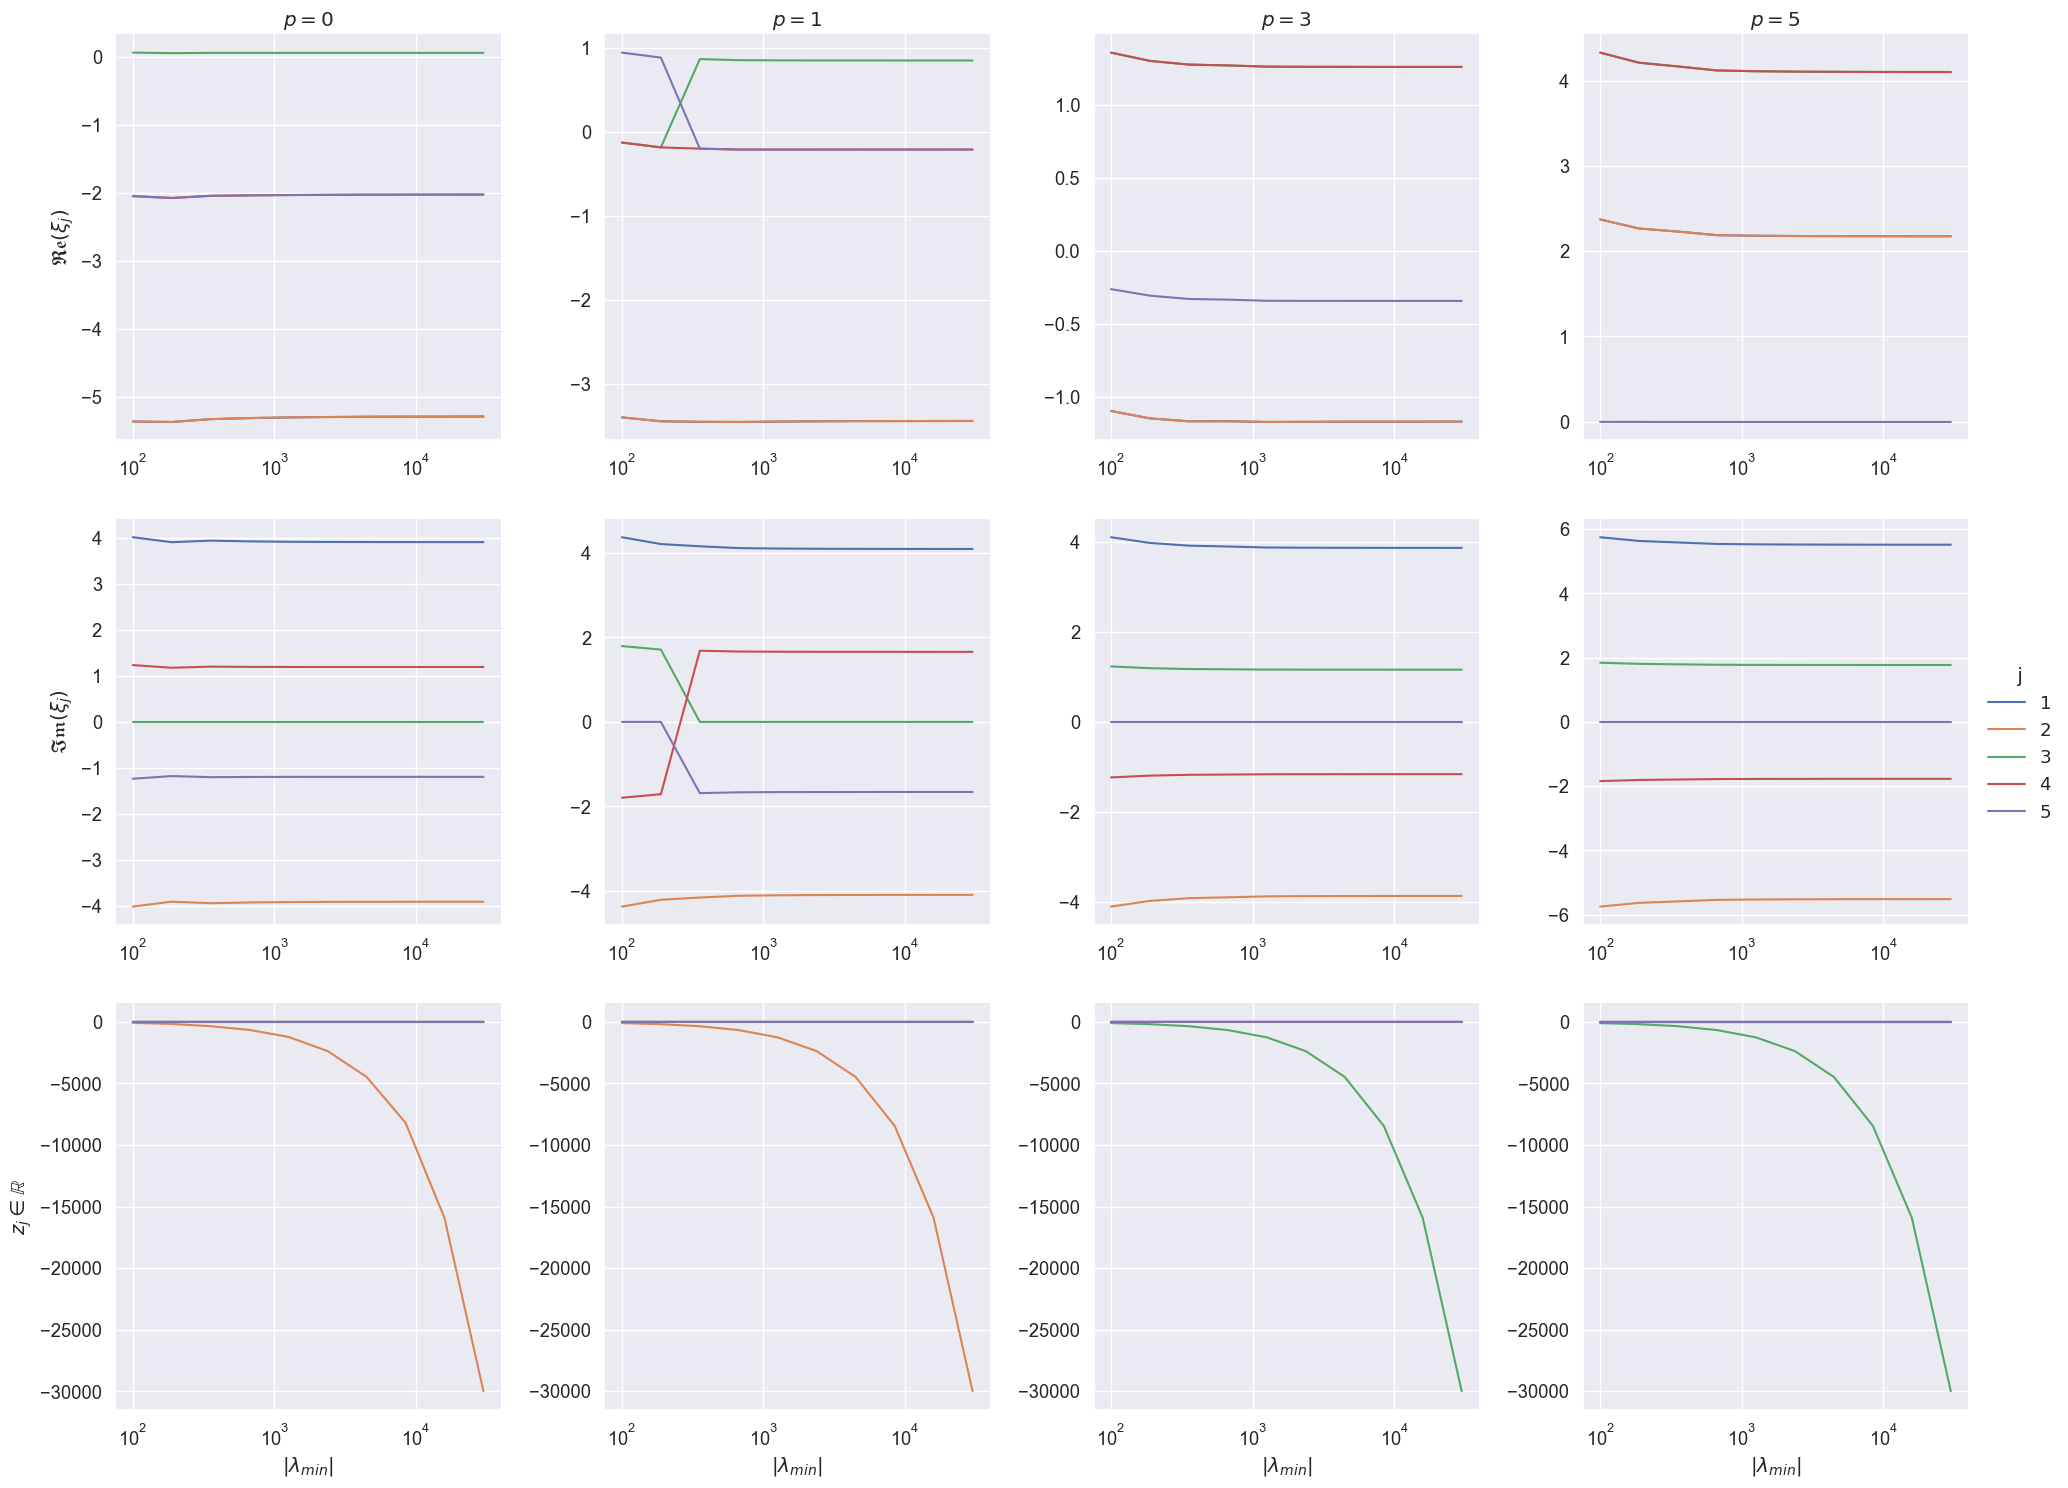

In [5]:
sort = False
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_j$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

poles_real_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
poles_real_['what'] = '$\\mathfrak{Re}(\\xi_j)$'
df_real = pd.concat([data, poles_real_], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

poles_imag_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
poles_imag_['what'] = '$\\mathfrak{Im}(\\xi_j)$'
df_imag = pd.concat([data, poles_imag_], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df = pd.concat([df_real, df_imag, df_nodes])
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$|\\lambda|$'}),
    x='$|\\lambda|$',
    y='$\\xi$',
    hue='j',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', ylabel='')

ps_ = list(set(ps))
for i, axs in enumerate(fg.axes):
    for j, ax in enumerate(axs):
        if i == 0:
            ax.set(title=f'$p = {ps_[j]}$')
        else:
            ax.set(title='')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_j)$')
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_j)$')
fg.axes[2, 0].set(ylabel='$z_j \in \\mathbb{R}$')

[Text(1057.9258875868056, 0.5, '$z_k$')]

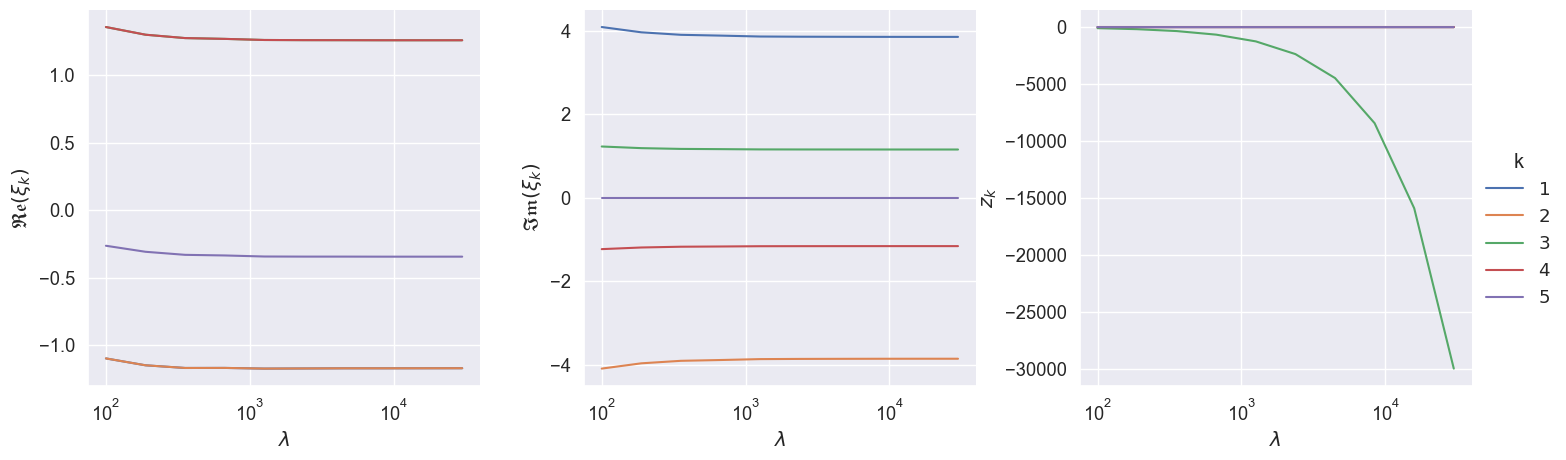

In [22]:
sort = False
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_k$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

poles_real_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
poles_real_['what'] = '$\\mathfrak{Re}(\\xi_k)$'
df_real = pd.concat([data, poles_real_], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

poles_imag_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
poles_imag_['what'] = '$\\mathfrak{Im}(\\xi_k)$'
df_imag = pd.concat([data, poles_imag_], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df = pd.concat([df_real, df_imag, df_nodes])
df['a'] = df['a'].abs()
df = df[(df['p'] == 3)]
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='k',
    col='what',
    # row='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', title='')

fg.axes.flatten()[0].set(ylabel='$\\mathfrak{Re}(\\xi_k)$')
fg.axes.flatten()[1].set(ylabel='$\\mathfrak{Im}(\\xi_k)$')
fg.axes.flatten()[2].set(ylabel='$z_k$')

# Experiments

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mmax_PA = 600
mmax_RA = 100
ns = [n ** 2 for n in range(100, 0, -10)]
as_ = [1000, 10000, 100000]
n_matrices = 5
eps = 1e-06


ds = []
pbar_n = tqdm(total=len(ns), desc='Sizes (n)', leave=True)
for n in ns:
    pbar_n.desc = f'Sizes (n={n})'
    pbar_n.refresh()

    # Get random vector v and normalize it
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)

    # Define the name of the test matrices
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']

    # Get the eigenvalues of A1 and A2
    eigs = {}
    A1 = get_FD_matrix(n=n, d=1, scale=False)
    eigs['A1'] = (
        sps.linalg.eigsh(A1, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A1, k=1, which='LA', return_eigenvectors=False).item(),
    )
    A2 = get_FD_matrix(n=(n ** .5), d=2, scale=False)
    eigs['A2'] = (
        sps.linalg.eigsh(A2, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A2, k=1, which='LA', return_eigenvectors=False).item(),
    )

    pbar_a = tqdm(total=len(as_), desc='Eigenvalues (a)', leave=False)
    for a in as_:
        pbar_a.desc = f'Eigenvalues (a={a})'
        pbar_a.refresh()
        # Get convergence data for the test matrices
        pbar_A = tqdm(total=n_matrices, desc='Matrices (A)', leave=False)
        for name, A in zip(names[:n_matrices], get_test_matrices(n=n, a=-a, b=-eps, eigs=eigs)[:n_matrices]):
            pbar_A.desc = f'Matrices (A={name})'
            pbar_A.refresh()

            d = approximation_convergence(
                A=A,
                v=v,
                nms=50,
                ps=[0, 1, 3, 5],
                mmax_PA=min(n, mmax_PA),
                mmax_RA=min(n, mmax_RA),
                interval=(-a, -eps),
            )
            d['name'] = [name] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

            pbar_A.update()

        # Get PA error estimation for this spectral interval
        d = get_bound_chebyshev(
            ps=[1],
            mmax=mmax_PA,
            nms=50,
            alpha=abs(a),
            vnorm=1,
        )
        d['name'] = ['bound'] * len(d['err'])
        d['n'] = [n] * len(d['err'])
        d['a'] = [a] * len(d['err'])
        ds.append(d)

        pbar_A.close()
        pbar_a.update()

    pbar_a.close()
    pbar_n.update()

pbar_n.close()
warnings.filterwarnings('default')

print('Done!')

In [4]:
# Build the dataframe
df = pd.concat([pd.DataFrame(d) for d in ds])

In [143]:
# Save the experiments
df.to_csv('experiments.csv', index=False)

In [140]:
# Load the experiments
df = pd.read_csv('experiments.csv')

# Plots

## Convergence for different $\varphi$-functions

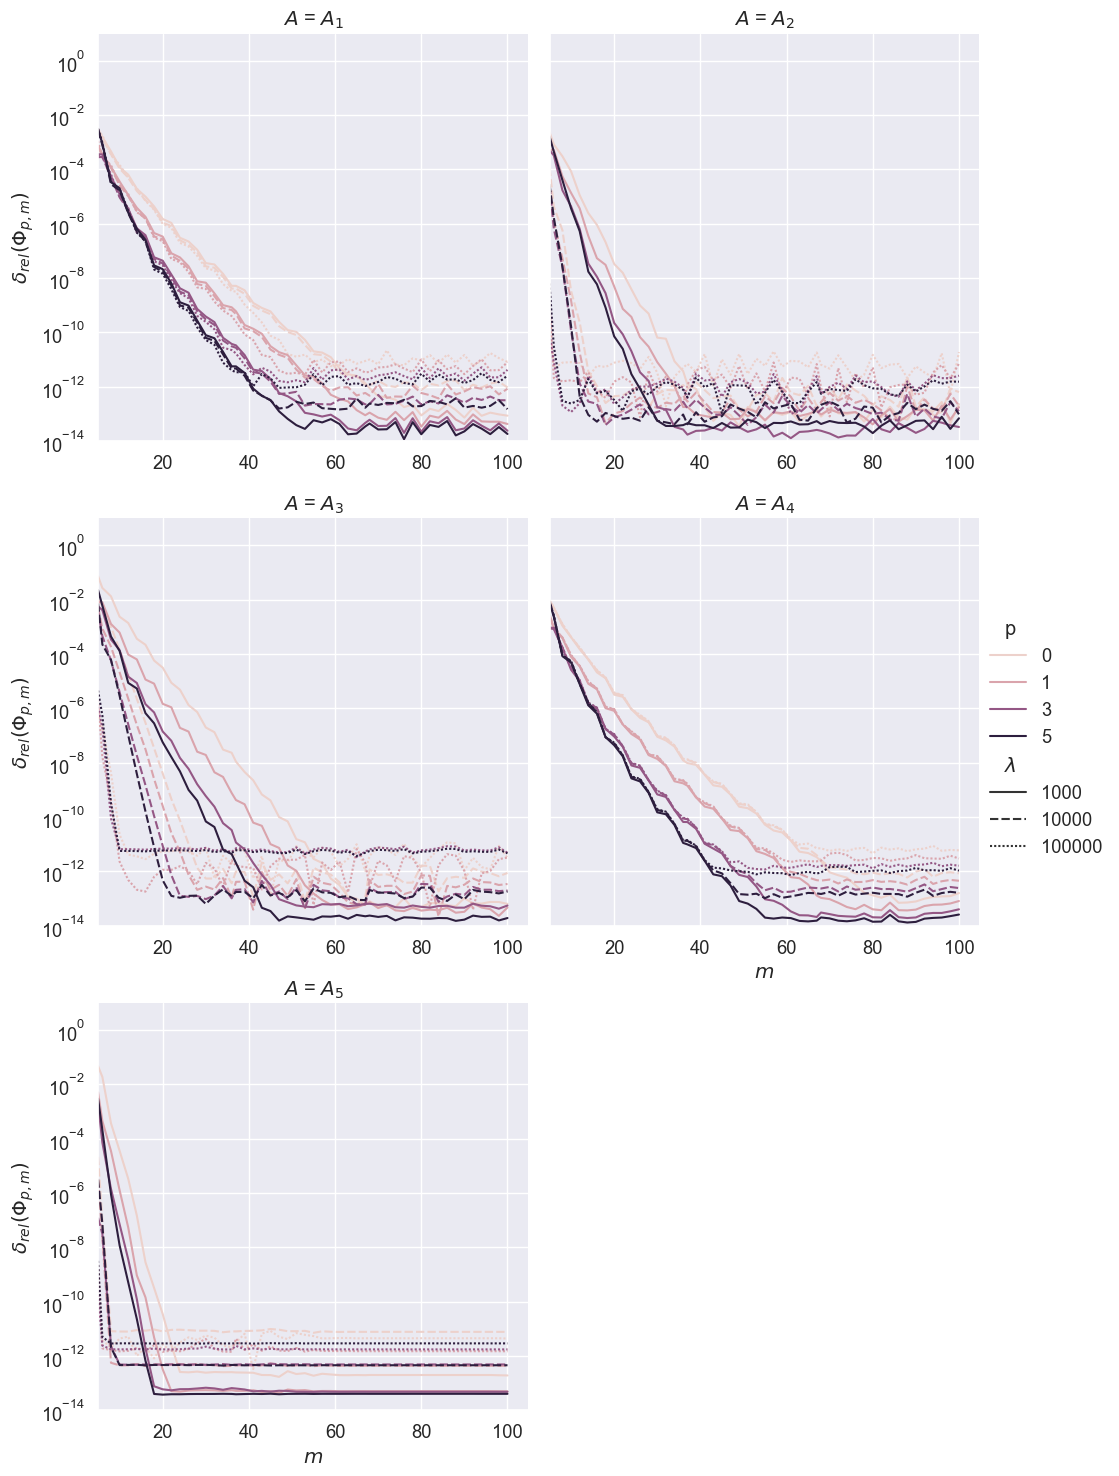

In [10]:
data = df[
    ((df['method'] == 'RA-ONES'))
    & ((df['name'] != 'bound'))
    & (df['n'] == 10000)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
);

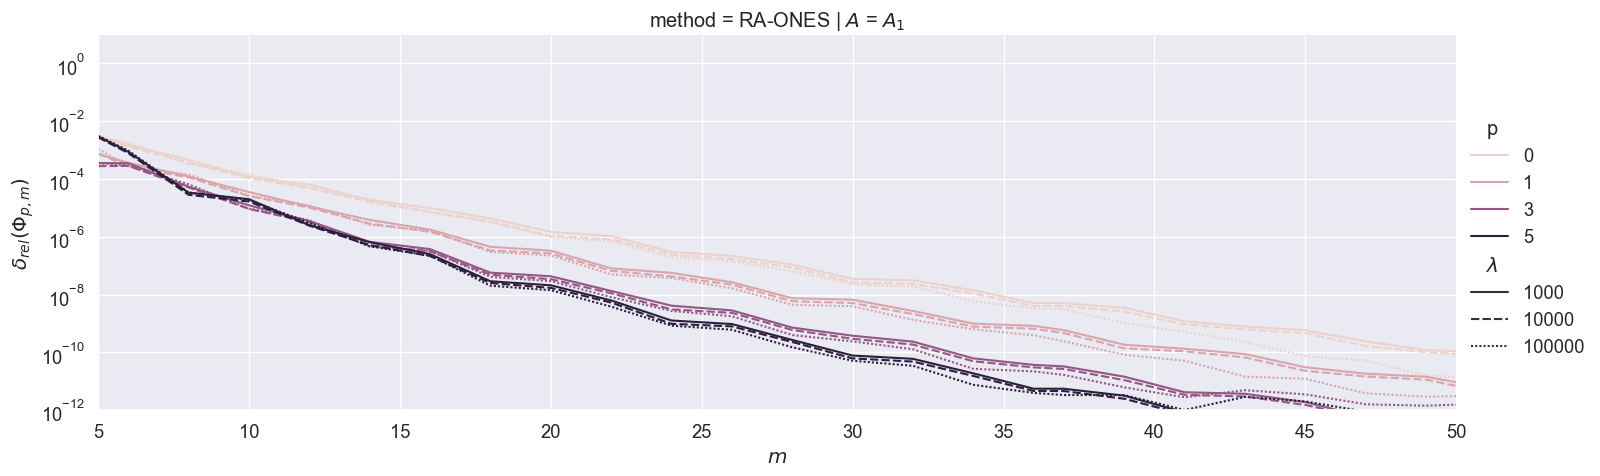

In [138]:
data = df[
    # phi functions
    (df['p'] != 10)

    # Method
    & ((df['method'] == 'RA-ONES'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == 10000) | (df['a'] == 5000) | (df['a'] == 1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    # & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    row='method',
    style='$\\lambda$',
    # col_wrap=2,
    facet_kws={'sharex': False},
    height=5,
    aspect=3,
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
);
fg.axes[0, 0].set(xlim=[5, 50]);

## Convergence for different matrices

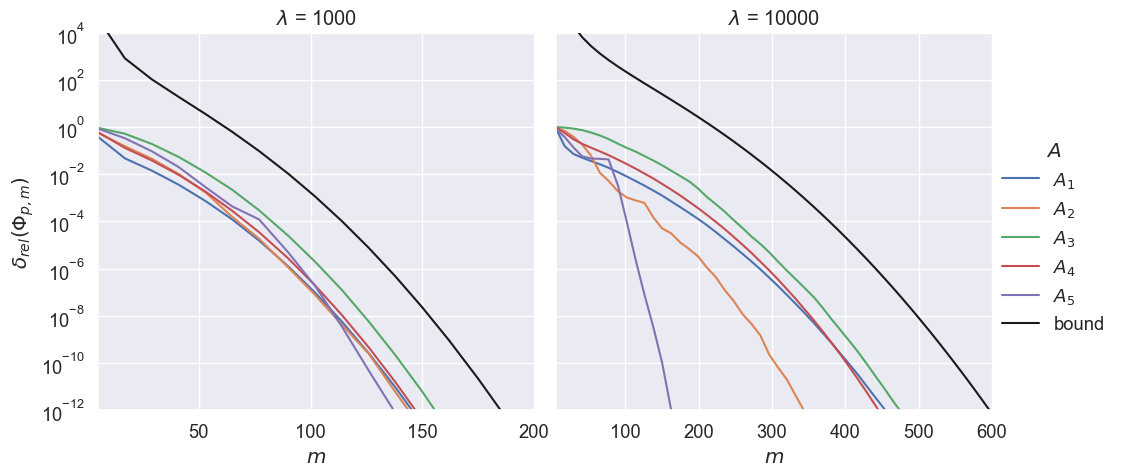

In [15]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & ((df['n'] == 10000))

    # Smallest eigenvalue
    & ((df['a'] == 10000) | (df['a'] == 1000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'bound'],
    col_order=[1000, 10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'k'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+04],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different methods

[(5.0, 20.0)]

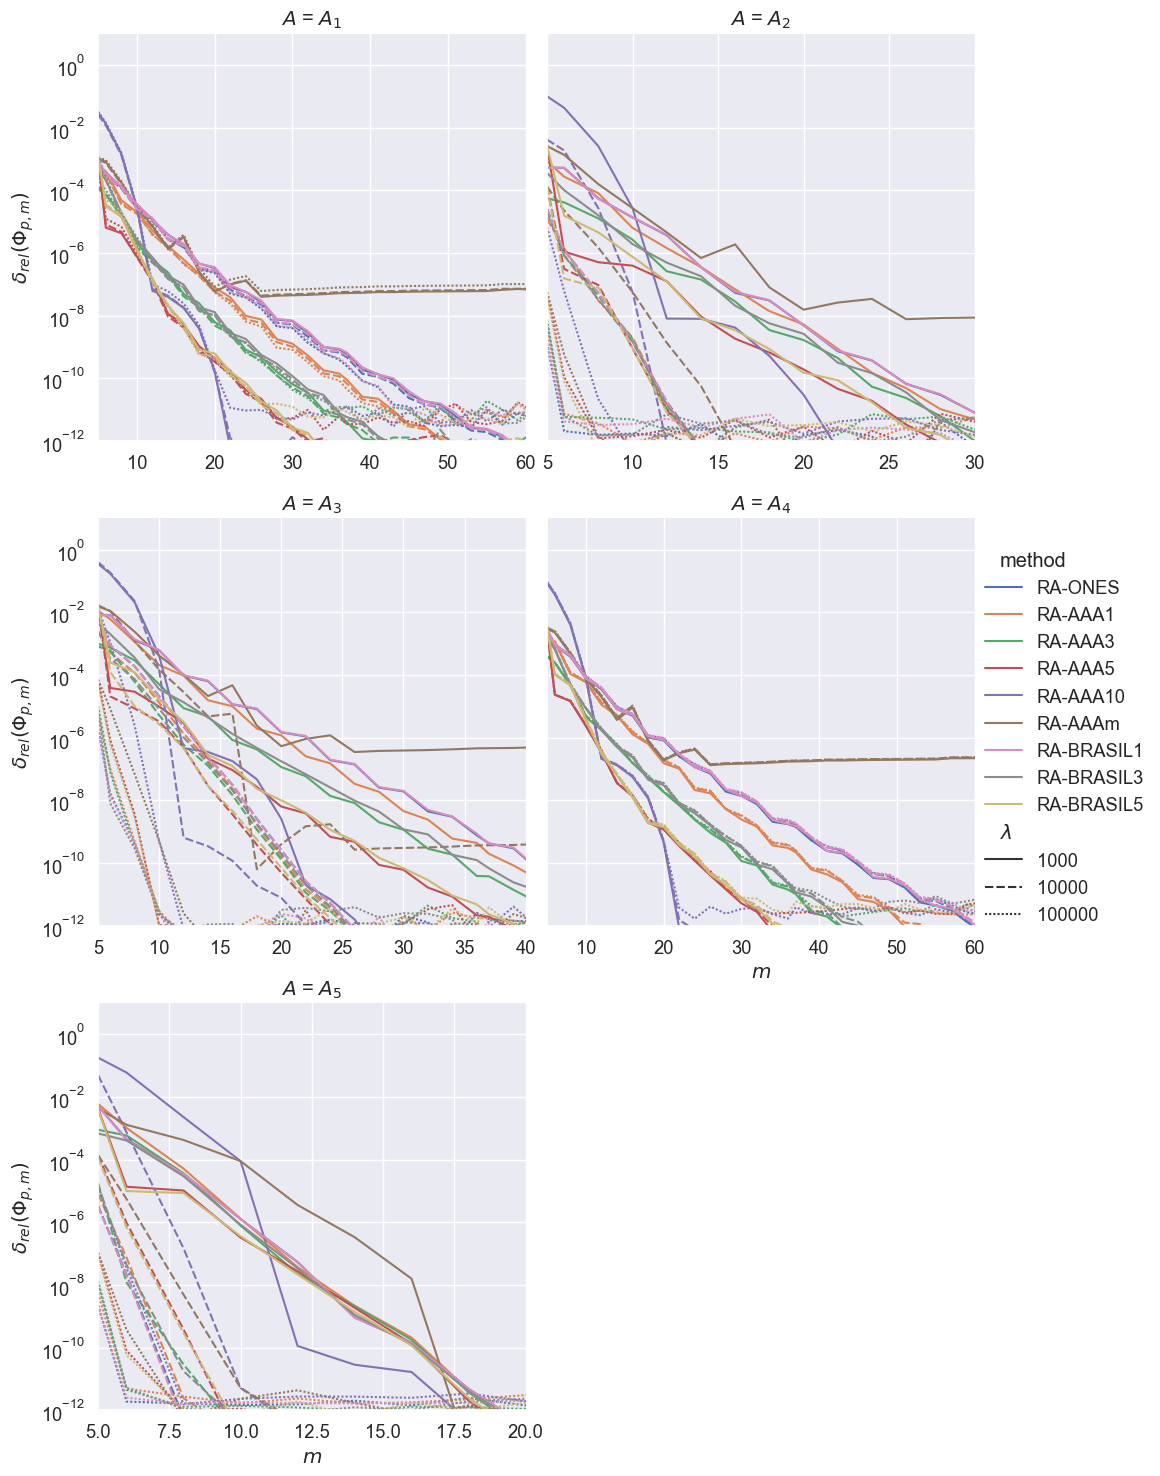

In [18]:
# TODO: Use this for comparing RA and RA-AAA
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] != 'EX') & (df['method'] != 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    style='$\\lambda$',
    col='$A$',
    hue='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)
fg.axes[0].set(xlim=[5, 60])
fg.axes[1].set(xlim=[5, 30])
fg.axes[2].set(xlim=[5, 40])
fg.axes[3].set(xlim=[5, 60])
fg.axes[4].set(xlim=[5, 20])

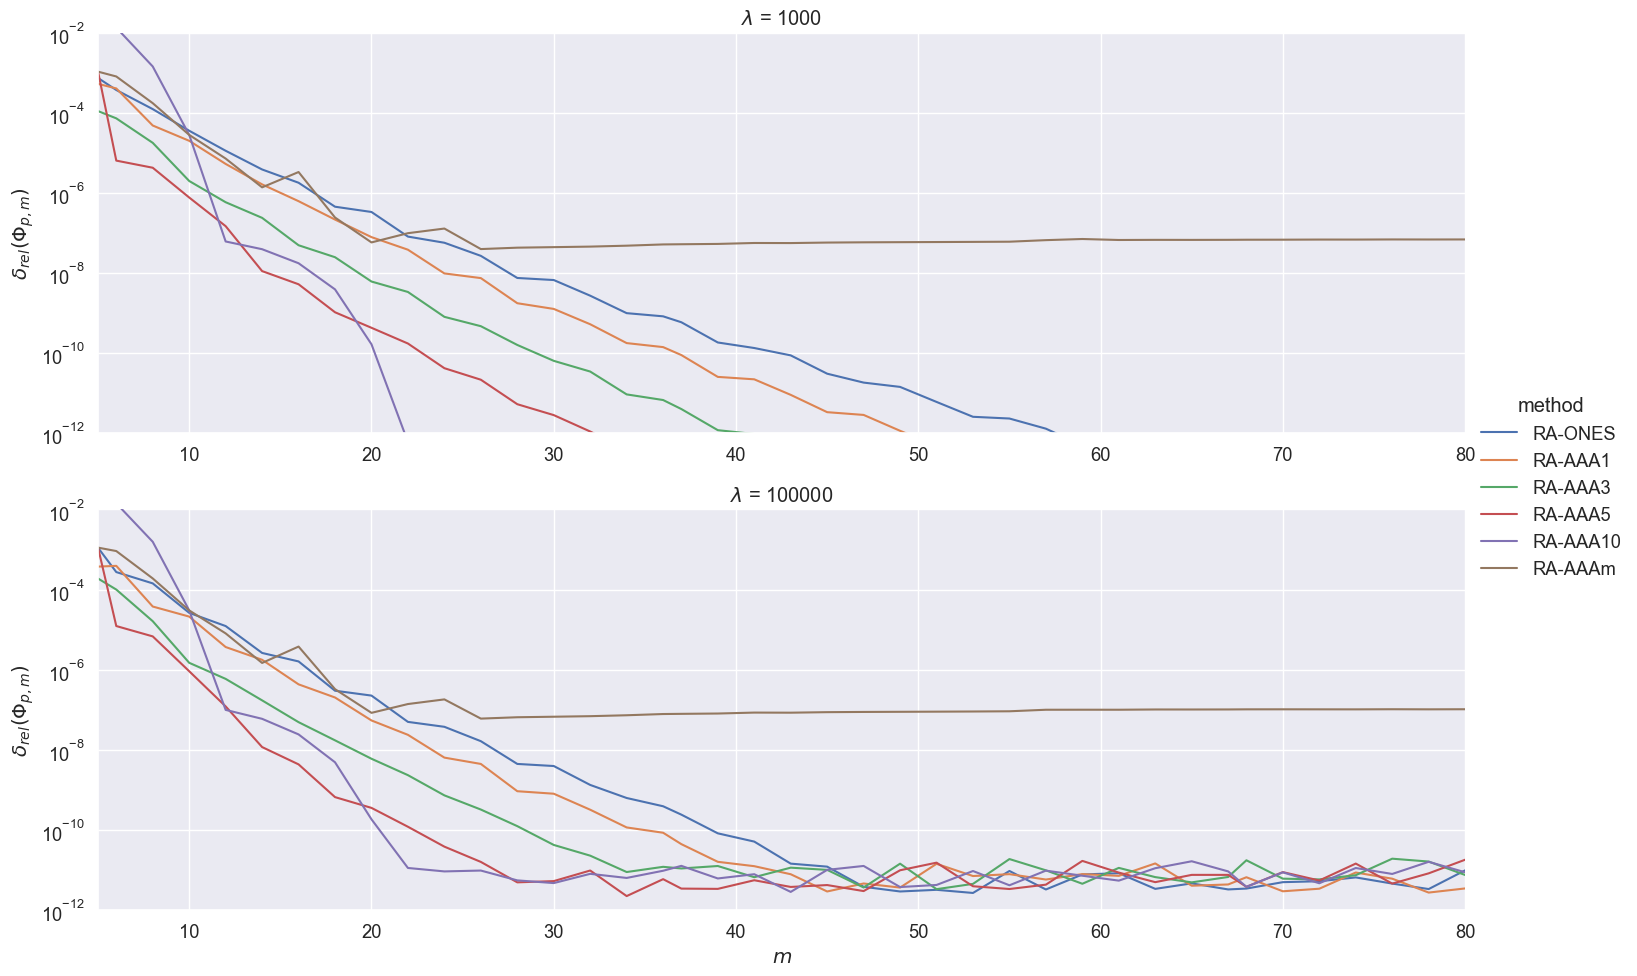

In [83]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & (((df['method'].str.contains('AAA'))) | (df['method'] == 'RA-ONES'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    & ((df['a'] == 100000) | (df['a'] == 1000))
].copy()

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    row='$\\lambda$',
    # col='$A$',
    hue='method',
    # col_wrap=2,
    height=5,
    aspect=3,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, 80],
    ylim=[1e-12, 1e-02],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

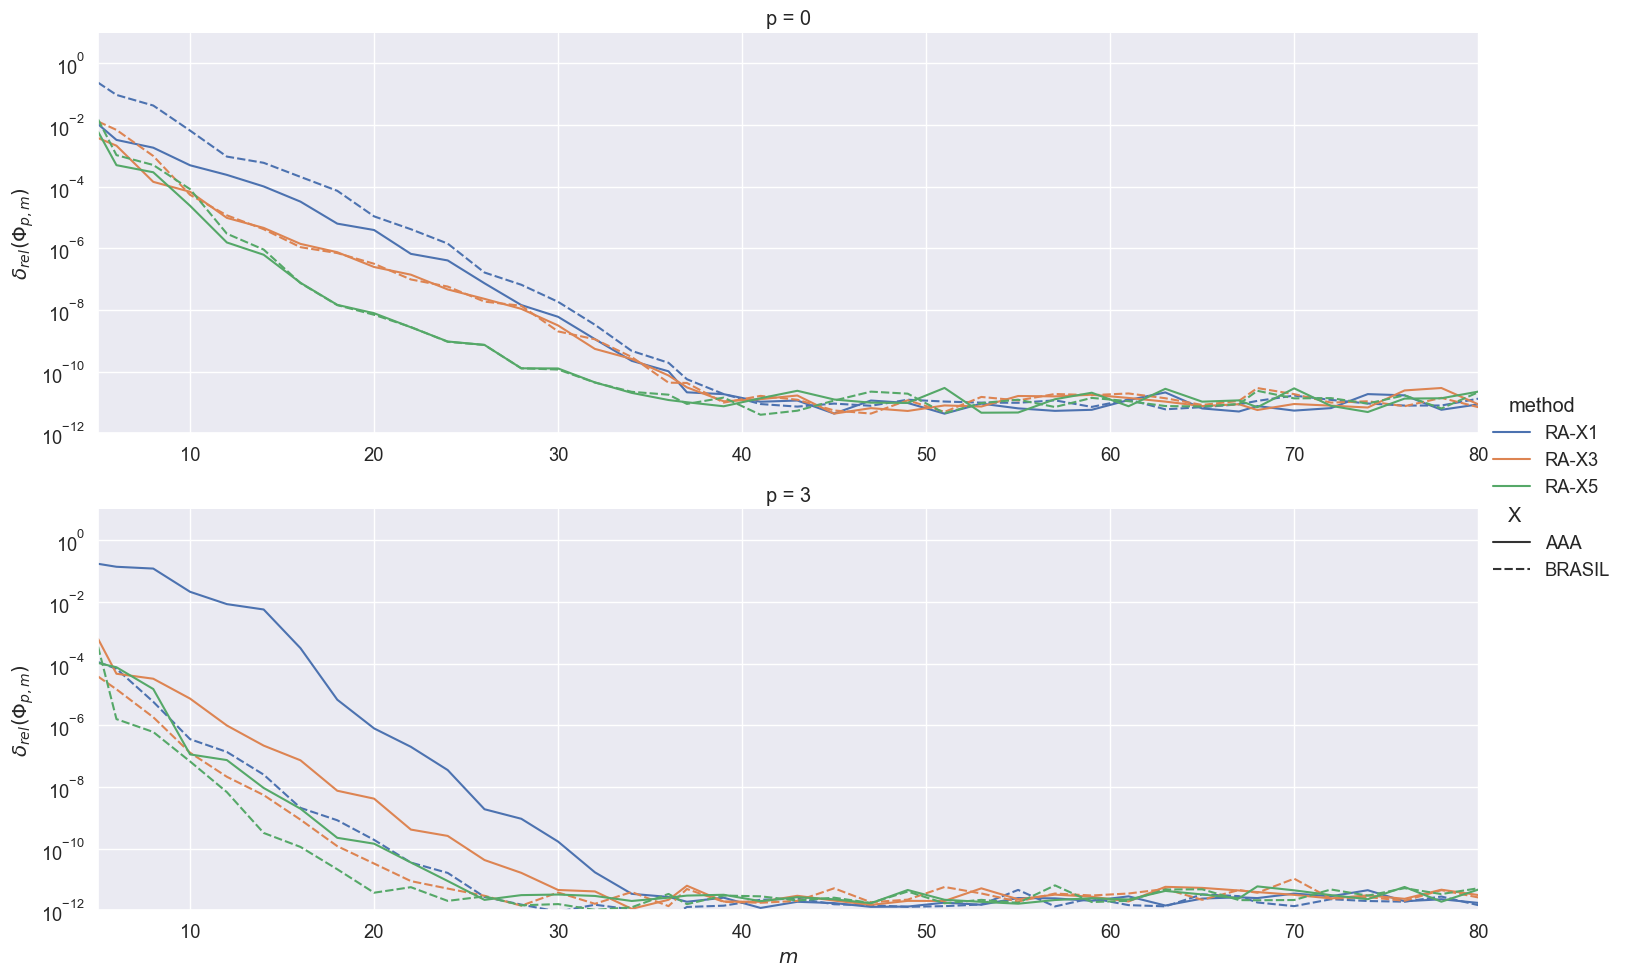

In [95]:
data = df[
    # phi functions
    ((df['p'] == 3) | (df['p'] == 0))

    # Method
    & (((df['method'].str.contains('AAA')) & (df['method'] != 'RA-AAAm') & (df['method'] != 'RA-AAA10')) | (df['method'].str.contains('BRASIL')))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    & ((df['a'] == 100000))
].copy()

data['X'] = None
data.loc[data['method'].str.contains('BRASIL'), 'X'] = 'BRASIL'
data.loc[data['method'].str.contains('AAA'), 'X'] = 'AAA'
data.loc[(data['method'] == 'RA-AAA1') | (data['method'] == 'RA-BRASIL1'), 'method'] = 'RA-X1'
data.loc[(data['method'] == 'RA-AAA3') | (data['method'] == 'RA-BRASIL3'), 'method'] = 'RA-X3'
data.loc[(data['method'] == 'RA-AAA5') | (data['method'] == 'RA-BRASIL5'), 'method'] = 'RA-X5'

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    # row='$\\lambda$',
    row='p',
    # col='$A$',
    style='X',
    hue='method',
    # col_wrap=2,
    height=5,
    aspect=3,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, 80],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

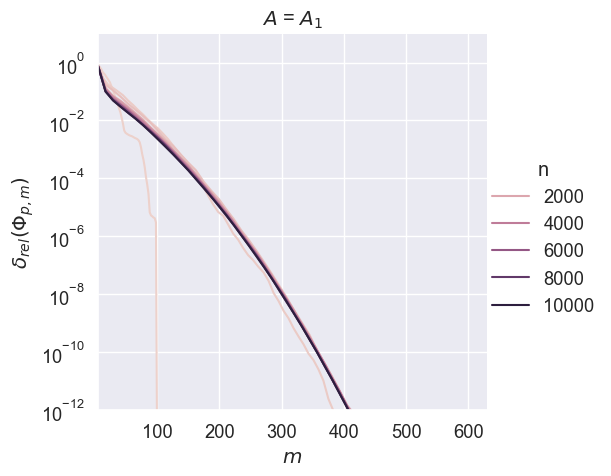

In [130]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == 10000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='n',
    # col='method',
    row='$A$',
    # col_wrap=2,
    # facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## CPU time with different n

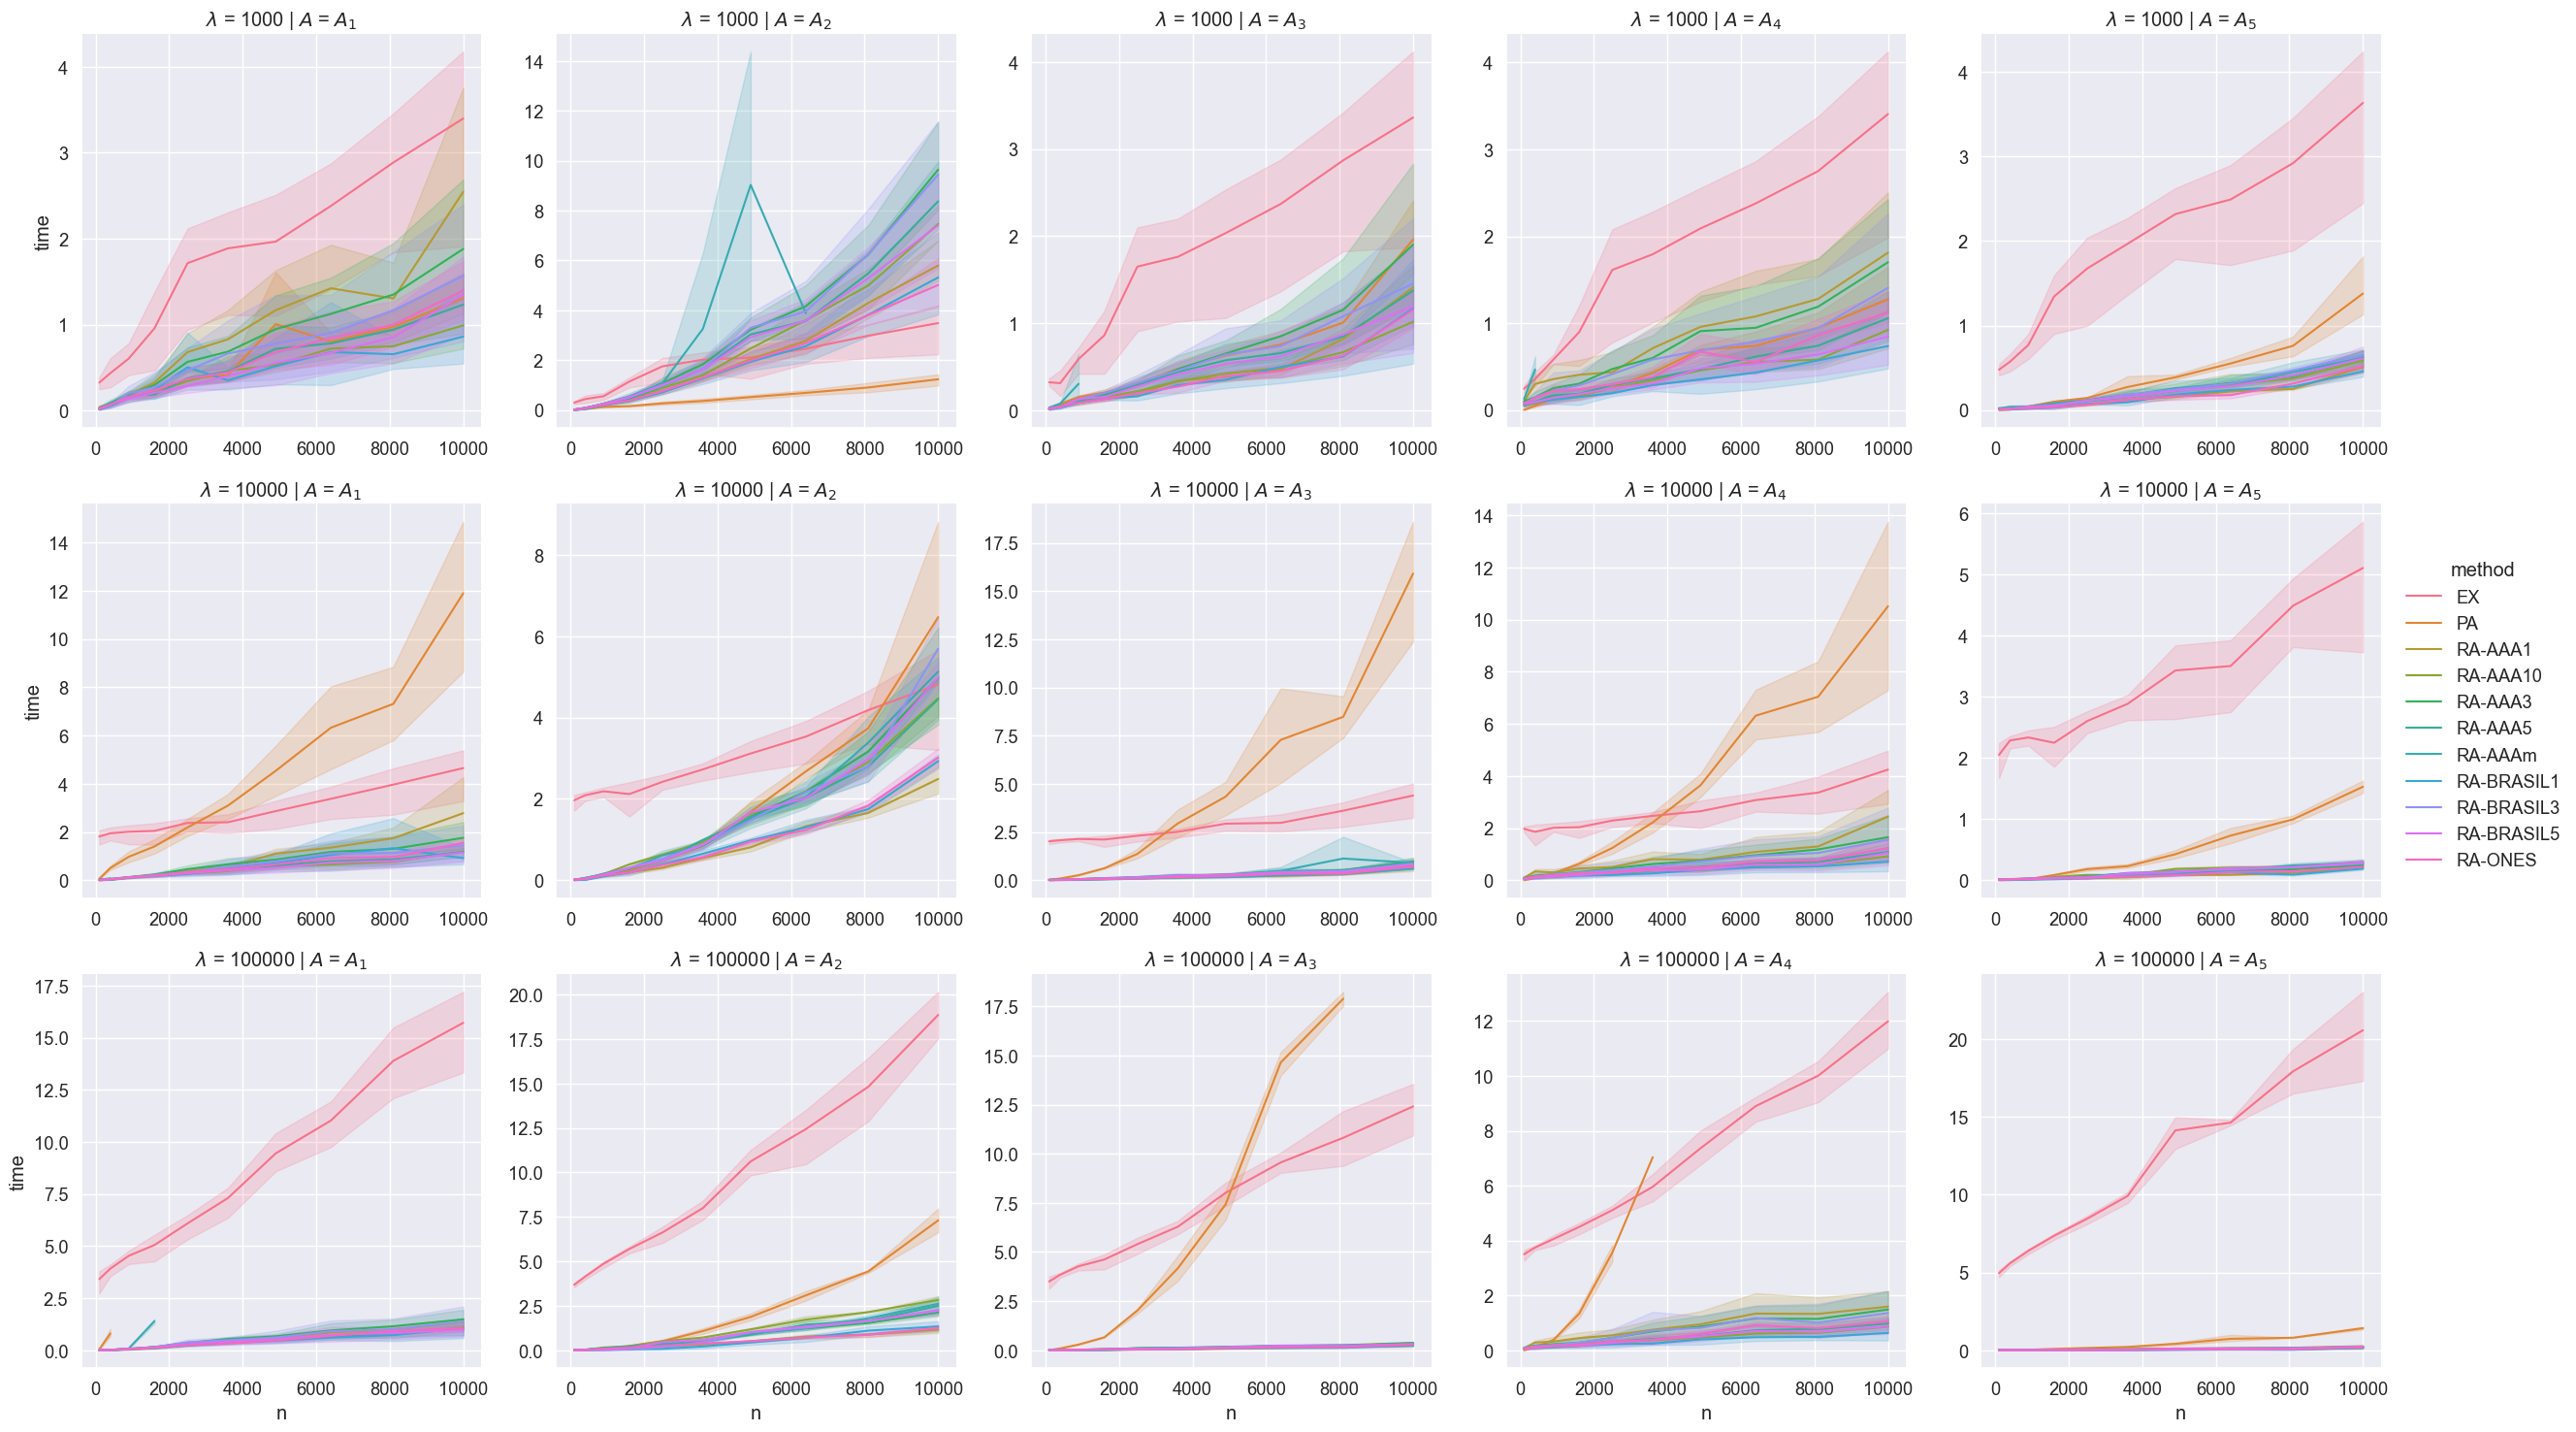

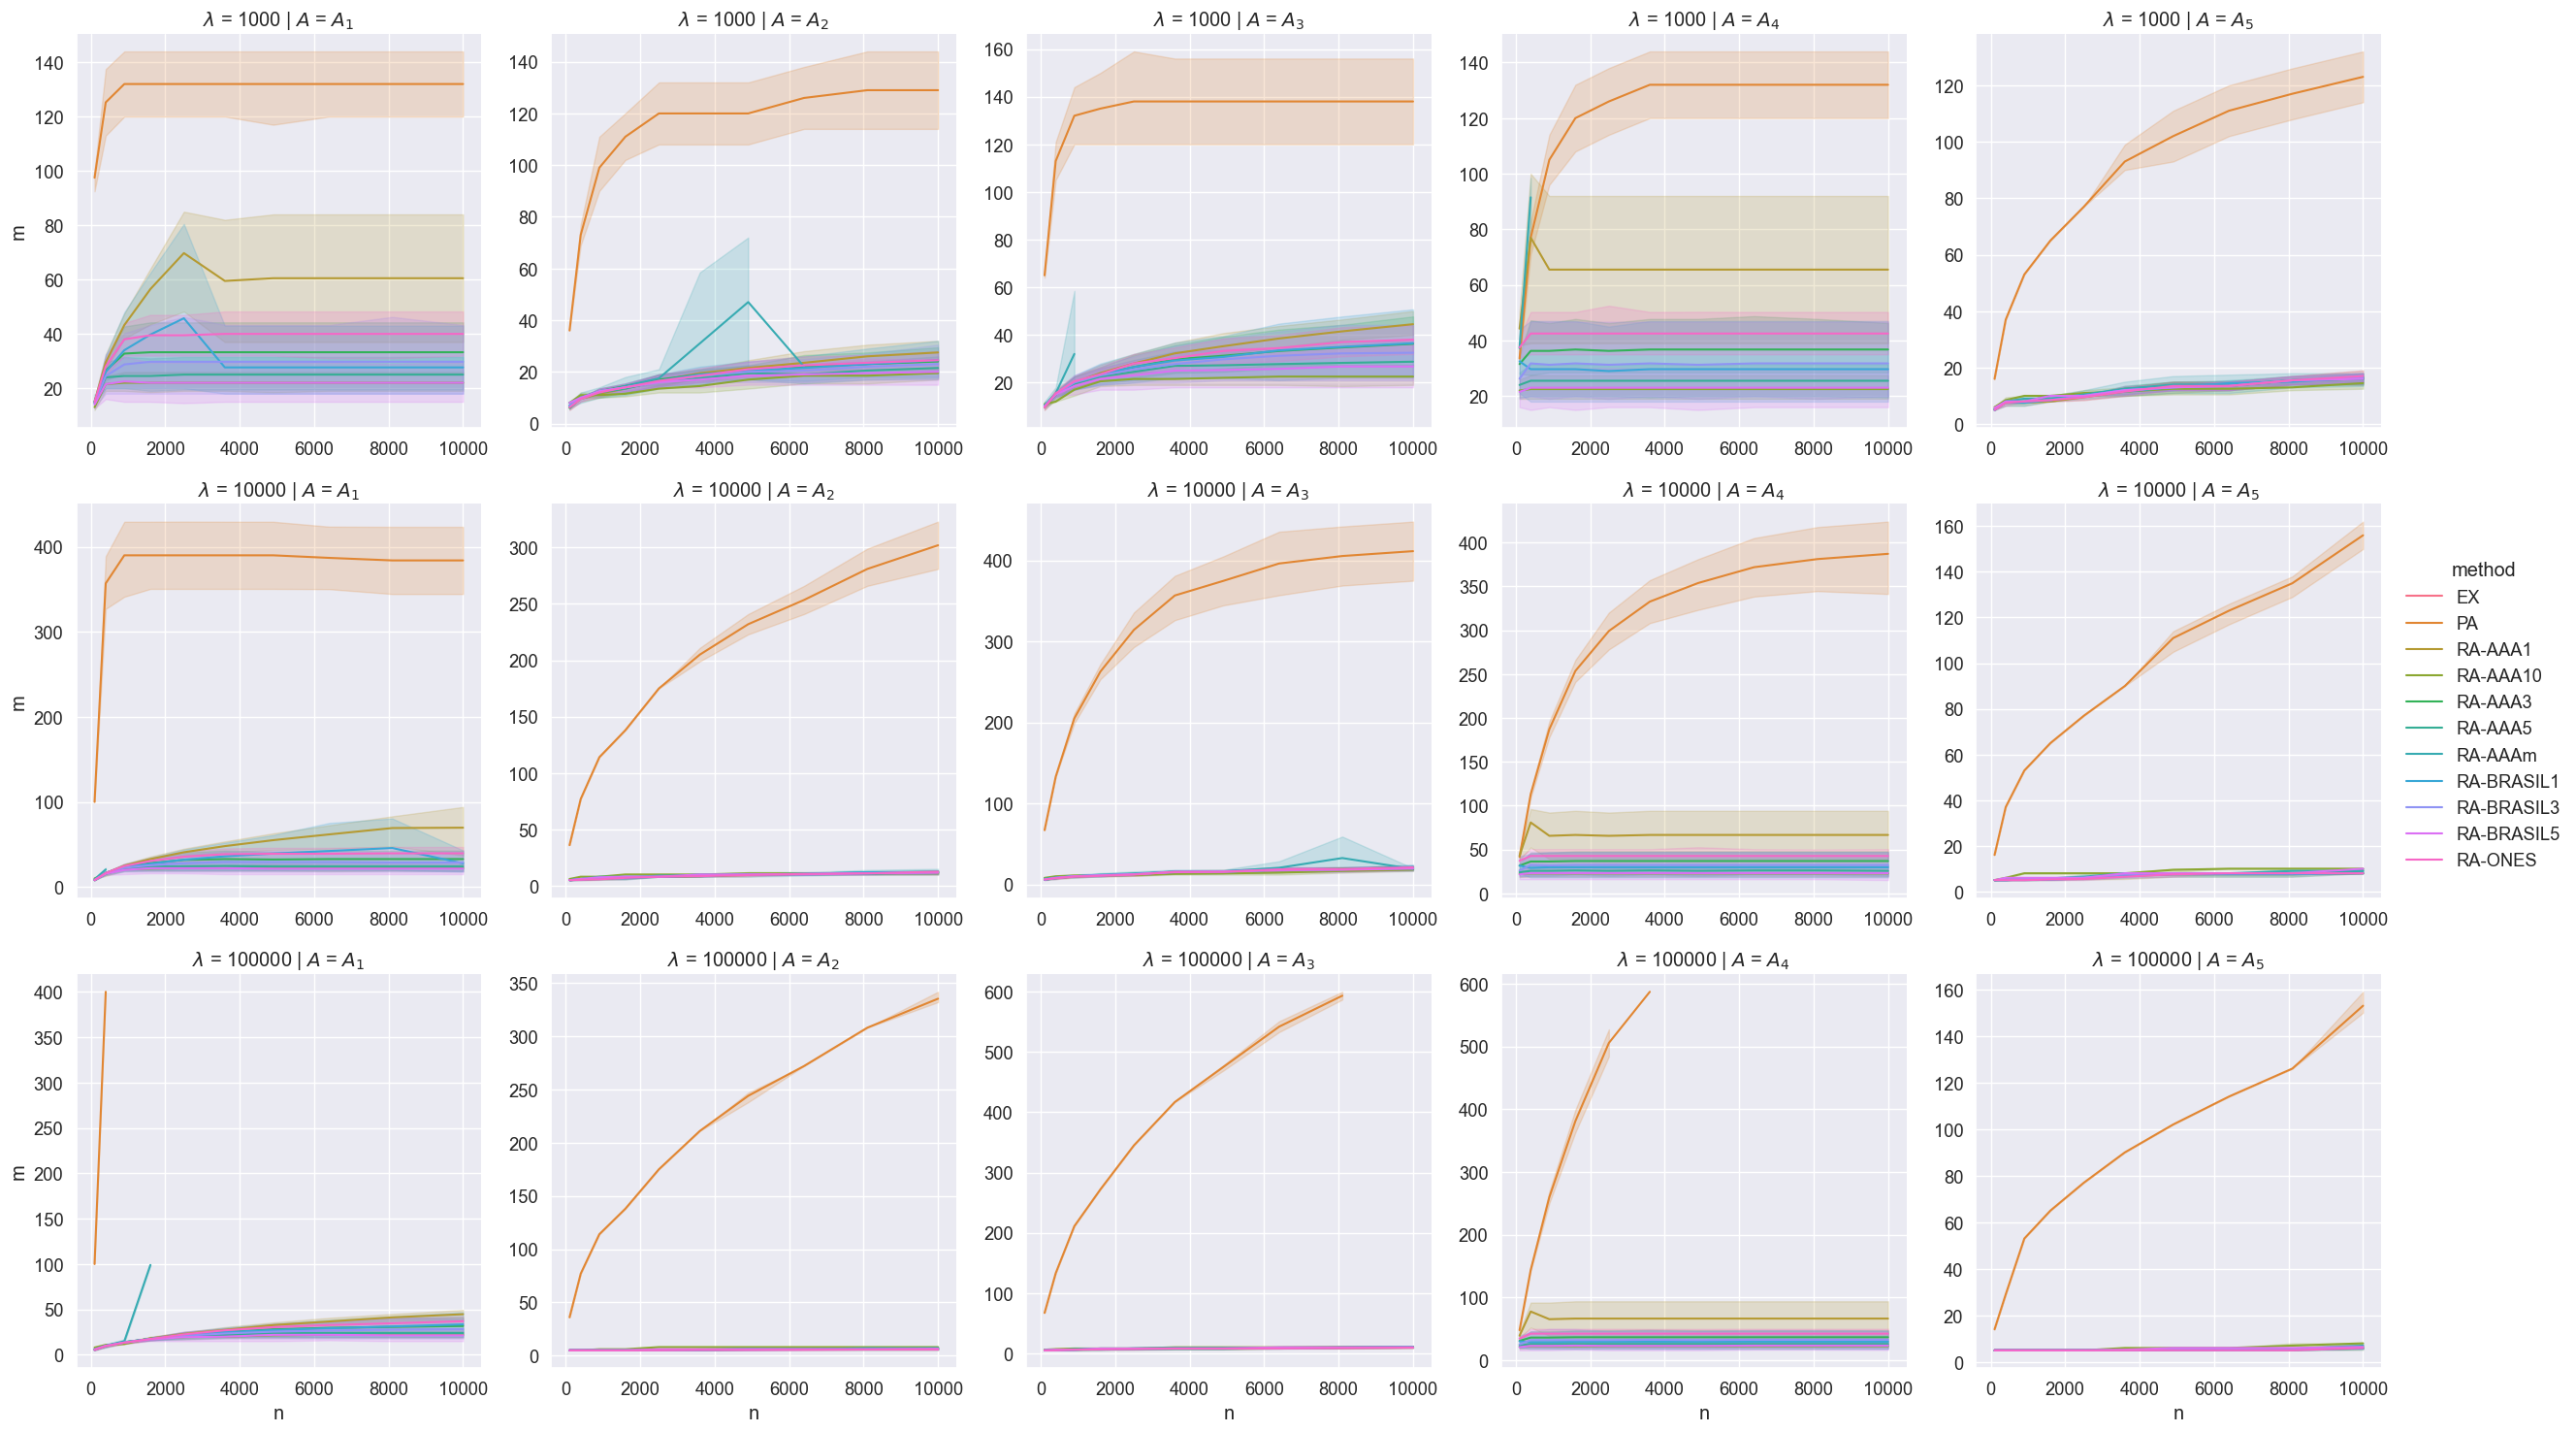

In [146]:
data = df[
    ((df['name'] != 'bound'))
    # & ((df['p'] == 5))
    # & ((df['method'].str.contains('RA')))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)

# Plot CPU time
fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

# Plot smallest m
fg = sns.relplot(
    data=data,
    x='n',
    y='m',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

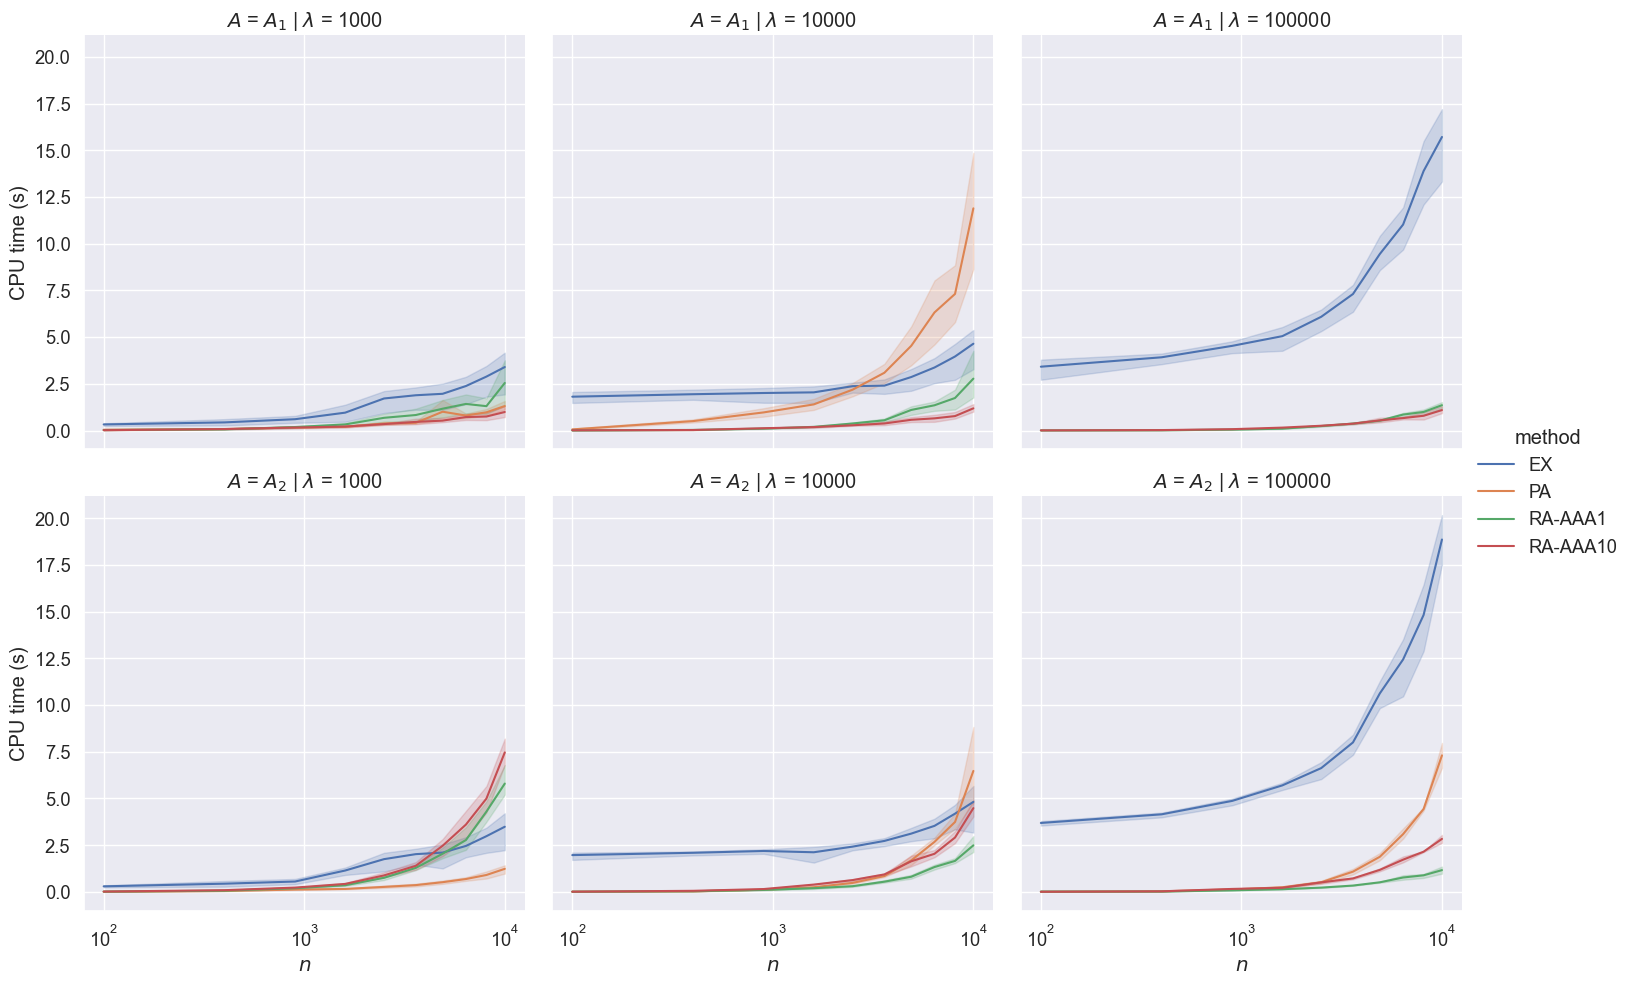

In [158]:
data = df[
    ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))
    & ((df['method'] == 'EX') | (df['method'] == 'PA') | (df['method'] == 'RA-AAA1') | (df['method'] == 'RA-AAA10'))
    & ~((df['a'] == 100000) & (df['method'] == 'PA') & (df['name'] == '$A_1$'))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)


fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    row='$A$',
    col='$\\lambda$',
    col_order=[1000, 10000, 100000],
    # facet_kws={'sharey': False}
)
fg.set(
    xscale='log',
    ylabel='CPU time (s)',
    xlabel='$n$',
)